## General Commentary
(this is also present in the README)
All run on a linux virtual box guest on a windows 10 host. Intel i5-7200u cpu, 2.5 GHz clock speed, two cores, four threads.

Initially, the multiprocessing implementation ran faster than the serial implementation for me. However, it suddenly started taking as long or longer, despite me not changing the code. I'm not sure why it changed, I tried several different implementations to try to speed it up, but nothing worked. My dask code consistently runs quite a bit faster though!

I chose four workers for everything because thats the number of threads I have. Trying different numbers of workers didn't seem to affect performance that much. I broke things into 8 chunks to prevent lags from a single slow worker.

In [1]:
from random import uniform
from math import sqrt
from time import time
from multiprocessing import Pool
import dask.array as da
import dask
from distributed import Client
import numpy as np

## Serial Implementation

In [2]:
def serial_throw_darts(n_darts):
    n_darts_in_circle = 0 #to store how many fall in circle
    t0 = time() #record start time
    for n in range(n_darts):
        x,y = uniform(0,1), uniform(0,1) #rand pos where dart falls
        #check if dart pos is w/i .5 of origin and thus inside circle
        if sqrt((x-.5)**2 + (y-.5)**2) <= .5: 
            n_darts_in_circle += 1
            
    execution_time = time() - t0 #time to run
    
    #A=pi*r**2, r=.5, so pi = A/.5**2, or pi = 4A
    #A is approximated by fraction of darts that fell in circle
    pi_approx = 4 * n_darts_in_circle/float(n_darts)
    
    dps = n_darts/execution_time #darts per second
    return pi_approx, n_darts, execution_time, dps

## Multiprocessing 
using a pool to break down the problem and map it to different workers. Each worker throws chunksize darts, then returns how many of those fell inside the circle

In [15]:
def multiproc_throw_darts(n_darts, n_workers):
    
    #to map to multiple workers, have each of them throw n_darts/(n_workers*2)
    #darts, tell you how many were in circle, and then sum over all of them
    
    #break it into n_workers * 2 jobs so that the slowest worker doesn't hold things up
    num_chunks = n_workers*2
    chunksize = int(n_darts/num_chunks)
    #create an array that is nchunks long, where each entry is chunksize
    chunks = [[chunksize]*(num_chunks)][0]
    t0 = time()
    
    #create pool
    pool = Pool(processes = n_workers)
    chunk_results = pool.map(throw_n_darts, chunks)
    n_darts_in_circle = sum(chunk_results)
    pool.close()
    execution_time = time() - t0 #time to run
    
    #A=pi*r**2, r=.5, so pi = A/.5**2, or pi = 4A
    #A is approximated by fraction of darts that fell in circle
    pi_approx = 4 * n_darts_in_circle/float(n_darts)
    
    dps = n_darts/execution_time #darts per second
    return pi_approx, n_darts, execution_time, dps

In [16]:
def throw_n_darts(n):
    n_darts_in_circle = 0
    for _ in range(n):
        x,y = uniform(0,1), uniform(0,1) #rand pos where dart falls
        #check if dart pos is w/i .5 of origin and thus inside circle
        if sqrt((x-.5)**2 + (y-.5)**2) <= .5: 
            n_darts_in_circle += 1
    return n_darts_in_circle
            

## Dask

Create a 2xn_darts dask array that represents the x,y coordinate pair for each dart thrown. Then do all the operations on that array. Only apply the operations in the final step, and compute them in parallel.

In [17]:
def dask_throw_darts(n_darts, chunksize):
    t0 = time()
    
    #create a 2 x n_darts array representing x + y coords of each dart
    xys = da.random.uniform(0,1,size=(2,n_darts), chunks = (2,chunksize))
    #for each single number in array, subtract .5 and raise to 2nd power
    xys = xys.map_blocks(lambda x: (x-.5) ** 2)
    #then add (x-.5)^2+(y-.5)^2 together
    xys = xys.sum(axis = 0)
    #then take the square root of the sum
    xys = xys**.5
    #finally, make all within the circle 1, and all outside the circle 0
    xys = xys.map_blocks(lambda x: np.asarray([1 if i<=.5 else 0 for i in x]))
    
    #then sum that array. compute in parallel with 4 workers.
    n_darts_in_circle = xys.sum().compute(num_workers = 4)
    
    execution_time = time() - t0 #time to run
    
    #A=pi*r**2, r=.5, so pi = A/.5**2, or pi = 4A
    #A is approximated by fraction of darts that fell in circle
    pi_approx = 4 * n_darts_in_circle/float(n_darts)
    
    dps = n_darts/execution_time #darts per second
    return pi_approx, n_darts, execution_time, dps

## Testing and Visualization

In [18]:
#run a bunch of iterations at a bunch of different ns to test performance This takes a LONG TIME
dart_ns = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6,10**7,10**8]
iters = 5
multp_ts = []
dask_ts = []
serial_ts = []
for n in dart_ns:
    multp_ts_temp = []
    dask_ts_temp = []
    serial_ts_temp = []
    for _ in range(iters):
        serial_ts_temp.append(serial_throw_darts(n)[2])
        multp_ts_temp.append(multiproc_throw_darts(n,4)[2])
        dask_ts_temp.append(dask_throw_darts(n, int(n/8))[2])
    multp_ts.append(multp_ts_temp)
    dask_ts.append(dask_ts_temp)
    serial_ts.append(serial_ts_temp)
        

In [19]:
import matplotlib.pyplot as plt

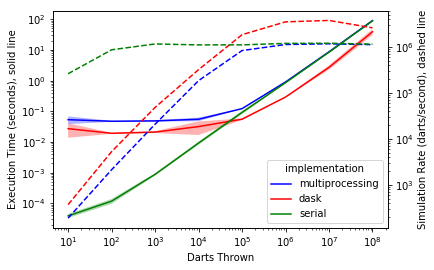

In [20]:
mp_means = []
d_means = []
s_means = []
for i in range(len(dart_ns)):
    mp_means.append(np.mean(multp_ts[i]))
    d_means.append(np.mean(dask_ts[i]))
    s_means.append(np.mean(serial_ts[i]))
    
mp_sds = []
d_sds = []
s_sds = []
for i in range(len(dart_ns)):
    mp_sds.append(np.std(multp_ts[i]))
    d_sds.append(np.std(dask_ts[i]))
    s_sds.append(np.std(serial_ts[i]))
    
plt.plot(dart_ns, mp_means,'b-', label = 'multiprocessing')
plt.plot(dart_ns, d_means,'r-', label = 'dask')
plt.plot(dart_ns, s_means,'g-', label = 'serial')
plt.legend(title = 'implementation', loc=4)

plt.fill_between(dart_ns, np.asarray(mp_means)+np.asarray(mp_sds),
                 np.asarray(mp_means)-np.asarray(mp_sds), facecolor = 'b', alpha = .3)

plt.fill_between(dart_ns, np.asarray(d_means)+np.asarray(d_sds),
                 np.asarray(d_means)-np.asarray(d_sds), facecolor = 'r', alpha = .3)

plt.fill_between(dart_ns, np.asarray(s_means)+np.asarray(s_sds),
                 np.asarray(s_means)-np.asarray(s_sds), facecolor = 'g', alpha = .3)


ax =plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax2 = ax.twinx()
ax2.plot(dart_ns, np.asarray(dart_ns)/np.asarray(mp_means),'b--', label = 'multiprocessing')
ax2.plot(dart_ns, np.asarray(dart_ns)/np.asarray(d_means),'r--', label = 'dask')
ax2.plot(dart_ns,np.asarray(dart_ns)/ np.asarray(s_means),'g--', label = 'serial')

ax2.set_yscale('log')

ax2.set_ylabel('Simulation Rate (darts/second), dashed line')
ax.set_ylabel('Execution Time (seconds), solid line')
ax.set_xlabel('Darts Thrown');